# 4. SED Fitting

## Imports

In [1]:
# Third party packages
from astropy import modeling
from astropy import table
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np
import scipy.cluster
import scipy.stats

# IPython configuration:
# Plots will appear inside the notebook
# instead of in a new window.
%matplotlib inline

## Read data

Let's load the (time, frequency, flux density) data set that we created in the previous step.

In [2]:
obs = table.Table.read('data/obs.ecsv', format='ascii.ecsv')

## Take inventory of data

Let's just make a scatter plot of time and frequency to get a sense of when and in what bands the data are well sampled.

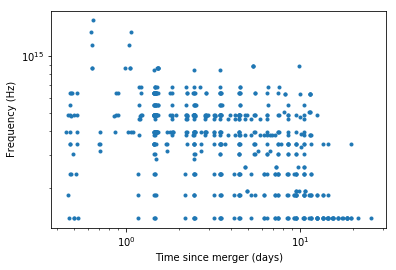

In [3]:
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time since merger (days)')
ax.set_ylabel('Frequency (Hz)')
ax.plot(obs['time'], obs['frequency'], '.')

## Cluster data by time

We need to identify time intervals where there is sufficiently broad frequency coverage to perform a fit. Often this requires painstaking manual inspection of the data. However, the GW170817 data set is sufficiently dense that we can simply use [*$k$-means clustering*](https://en.wikipedia.org/wiki/K-means_clustering) to automatically group the data by observation time.

In [4]:
# Take the logarithm of the observation times
# because the data get sparser as time advances.
data = np.log10(obs['time'] / u.day)

# Identify centers of clusters.
# The second argument controls the number of clusters.
# Play around with this number to group the data in
# different ways!
means, _ = scipy.cluster.vq.kmeans(data, 15)

# Sort the mean values so that cluster number
# advances monotonically with time.
means.sort()

# Identify the cluster assignemtns
cluster, _ = scipy.cluster.vq.vq(data, means)

### Visualize cluster assignments

We can use the powerful Astropy method [`Table.group_by`](http://docs.astropy.org/en/stable/table/operations.html#grouped-operations) to loop over the subset of the table that belongs to each cluster.

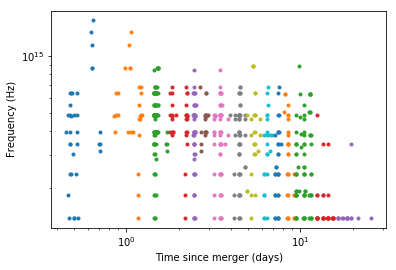

In [5]:
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time since merger (days)')
ax.set_ylabel('Frequency (Hz)')
for group in obs.group_by(cluster).groups:
    ax.plot(group['time'], group['frequency'], '.')

## Plot SEDs

Now we will plot the spectral energy distribution at each time.

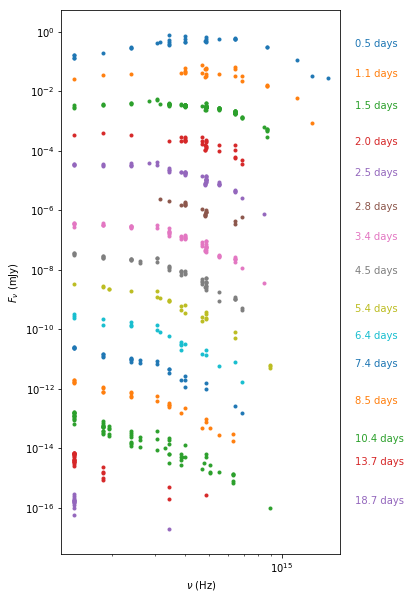

In [6]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$ (Hz)')
ax.set_ylabel(r'$F_\nu$ (mJy)')
for i, group in enumerate(obs.group_by(cluster).groups):
    # Shift each plot vertically by an amount
    # proportional to the cluster number to separate
    # the SEDs on the axes.
    shift = 10**(-i)

    t = scipy.stats.gmean(group['time'])
    nu_obs = group['frequency'].quantity
    fnu_obs = group['fluxdensity'].quantity

    lines, = ax.plot(nu_obs, shift * group['fluxdensity'], '.')
    color = lines.get_color()
    ax.text(
        2e15, shift * scipy.stats.gmean(fnu_obs / u.mJy),
        '{:.1f} days'.format(np.around(t, 1)),
        color=color)

We can already see by eye that the spectrum looks broadly similar to Planck's law, with the peak frequency decreasing with time (e.g., with the temperature decreasing with time).

## Epoch-by-epoch blackbody fits

Let's fit a blackbody to the data in each epoch.

**FIXME**: I'm using the [`astropy.modeling`](http://docs.astropy.org/en/stable/modeling/index.html) module, but this makes this way too easy for the students!

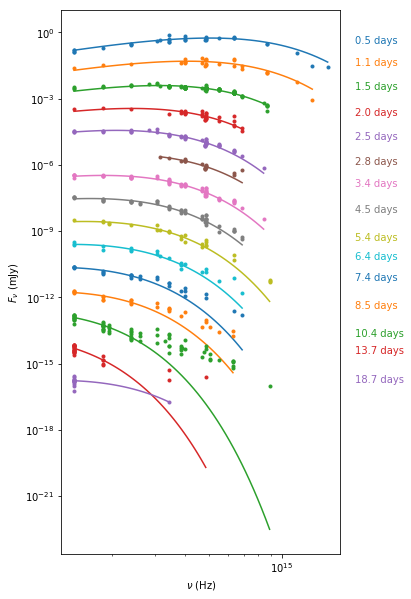

In [7]:
model = modeling.models.BlackBody1D()
fit = modeling.fitting.LevMarLSQFitter()

fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$ (Hz)')
ax.set_ylabel(r'$F_\nu$ (mJy)')
for i, group in enumerate(obs.group_by(cluster).groups):
    # Shift each plot vertically by an amount
    # proportional to the cluster number to separate
    # the SEDs on the axes.
    shift = 10**(-i)

    t = scipy.stats.gmean(group['time'])
    nu_obs = group['frequency'].quantity
    fnu_obs = group['fluxdensity'].quantity

    model = fit(model, nu_obs, fnu_obs)
    nu_fit = np.logspace(np.log10(nu_obs.min() / u.Hz),
                         np.log10(nu_obs.max() / u.Hz)) * u.Hz
    fnu_fit = model(nu_fit)

    lines, = ax.plot(nu_obs, shift * fnu_obs, '.')
    color = lines.get_color()
    ax.plot(nu_fit, shift * fnu_fit, color=color)
    ax.text(
        2e15, shift * scipy.stats.gmean(fnu_obs / u.mJy),
        '{:.1f} days'.format(np.around(t, 1)),
        color=color)

Note that at $t \gtrsim$ 7 days, the cooling blackbody still fits the near-infrared data well, but significantly underpredicts the optical and UV!